In [49]:
import pandas as pd
import numpy as np
import os
import dagshub
import mlflow
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
from matplotlib_venn import venn2
from dotenv import load_dotenv
import mlflow
import io
# import mlflow.pandas
# import mlflow.sklearn
# from mlflow.models.signature import infer_signature
load_dotenv()
dagshub.init(repo_owner='qetibakh', repo_name='Final', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/qetibakh/Final.mlflow')

Initialized MLflow to track repo "qetibakh/Final"

Repository qetibakh/Final initialized!

In [26]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
stores_df = pd.read_csv('data/stores.csv')
features_df = pd.read_csv('data/features.csv')
train_df['Date'] = train_df['Date'].astype('datetime64[ns]')

In [27]:
features_df['Date'] = features_df['Date'].astype('datetime64[ns]')
features_df['year'] = features_df['Date'].dt.year
features_df['month'] = features_df['Date'].dt.month
features_df['dayofweek'] = features_df['Date'].dt.dayofweek

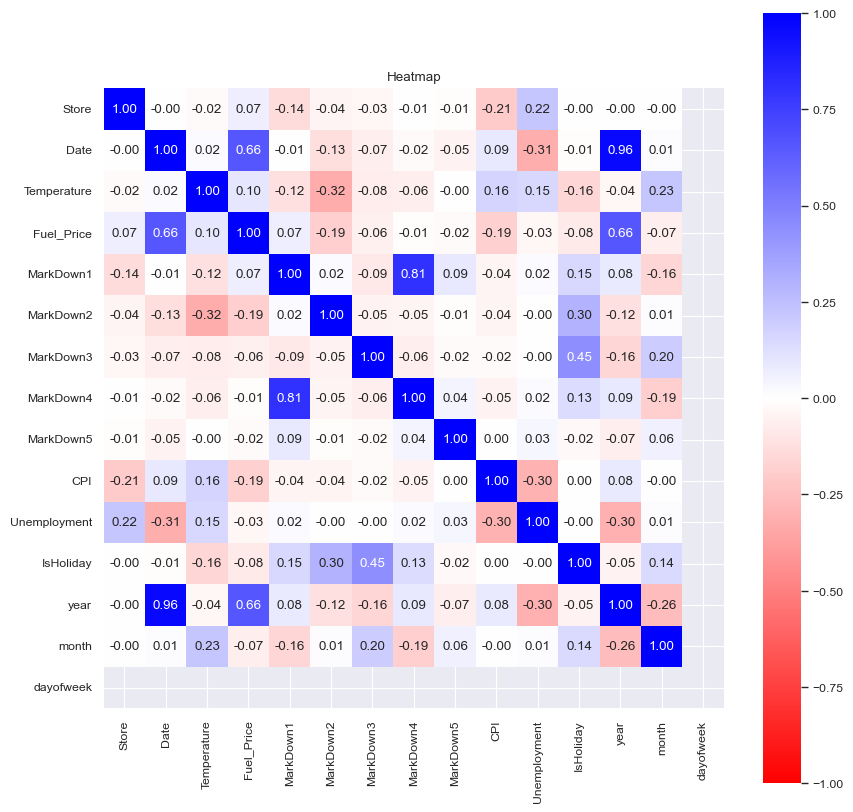

In [28]:
cols = features_df.columns
sns.set_context('paper')
fig = plt.subplots(figsize=(10, 10))
plt.title(f"Heatmap")
sns.heatmap(features_df[cols].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='bwr_r', square=True)
plt.show()

In [29]:
df = pd.merge(train_df,stores_df,how = 'inner',on = 'Store')

In [30]:
df = pd.merge(train_df,features_df,on = ['Store','Date'],how = 'inner').drop(columns = 'IsHoliday_x',axis = 1).rename(columns = {'IsHoliday_y':'IsHoliday','Weekly_Sales':'Target'})

In [31]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Target                 float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
year                     int32
month                    int32
dayofweek                int32
dtype: object

In [32]:
df.describe()

,Store,Dept,Date,Target,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,year,month,dayofweek
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,2010.968591,6.449510,4.0
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,2010.000000,1.000000,4.0
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,2010.000000,4.000000,4.0
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,2011.000000,6.000000,4.0
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,2012.000000,9.000000,4.0
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,4.0
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,0.796876,3.243217,0.0


In [33]:
df.isna().sum()/df.shape[0]

Store           0.000000
Dept            0.000000
Date            0.000000
Target          0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
IsHoliday       0.000000
year            0.000000
month           0.000000
dayofweek       0.000000
dtype: float64

In [34]:
fillna = df.isna().sum()[df.isna().sum() != 0].index.to_list()
fillna

['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

In [35]:
for i in fillna:
    mean = df[i].mean()
    median = df[i].median()
    df[f'{i}_mean'] = df[i].fillna(mean)
    df[i] = df[i].fillna(median)

In [36]:
df.isna().sum().sum()

np.int64(0)

In [37]:
df.describe()

,Store,Dept,Date,Target,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,CPI,Unemployment,year,month,dayofweek,MarkDown1_mean,MarkDown2_mean,MarkDown3_mean,MarkDown4_mean,MarkDown5_mean
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,...,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,6026.195471,1021.307467,484.687953,2090.196076,...,171.201947,7.960289,2010.968591,6.449510,4.0,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,...,126.064000,3.879000,2010.000000,1.000000,4.0,0.270000,-265.760000,-29.100000,0.220000,135.160000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,5347.450000,192.000000,24.600000,1481.310000,...,132.022667,6.891000,2010.000000,4.000000,4.0,7246.420196,3334.628621,115.390000,3383.168256,4628.975079
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,...,182.318780,7.866000,2011.000000,6.000000,4.0,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,5347.450000,192.000000,24.600000,1481.310000,...,212.416993,8.572000,2012.000000,9.000000,4.0,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,...,227.232807,14.313000,2012.000000,12.000000,4.0,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,5039.770624,5060.726828,5527.479863,3669.249108,...,39.159276,1.863296,0.796876,3.243217,0.0,4956.920816,4867.493911,5487.601593,3560.353127,3573.795304


In [38]:
df.columns
feature_engineering = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','MarkDown1_mean', 'MarkDown2_mean', 'MarkDown3_mean', 'MarkDown4_mean','MarkDown5_mean']

In [39]:
for col in feature_engineering:
    df[f"{col}_log"] = np.log(df[col] - df[col].min() + 1)
    df[f"{col}_boxcox"] = np.nan
    df.loc[df[col].notna(), f"{col}_boxcox"], _ = stats.boxcox(df[df[col].notna()][col] - df[col].min() + 1)
    df[f"{col}_yeojohnson"] = np.nan
    df.loc[df[col].notna(), f"{col}_yeojohnson"], _ = stats.yeojohnson(df[df[col].notna()][col])

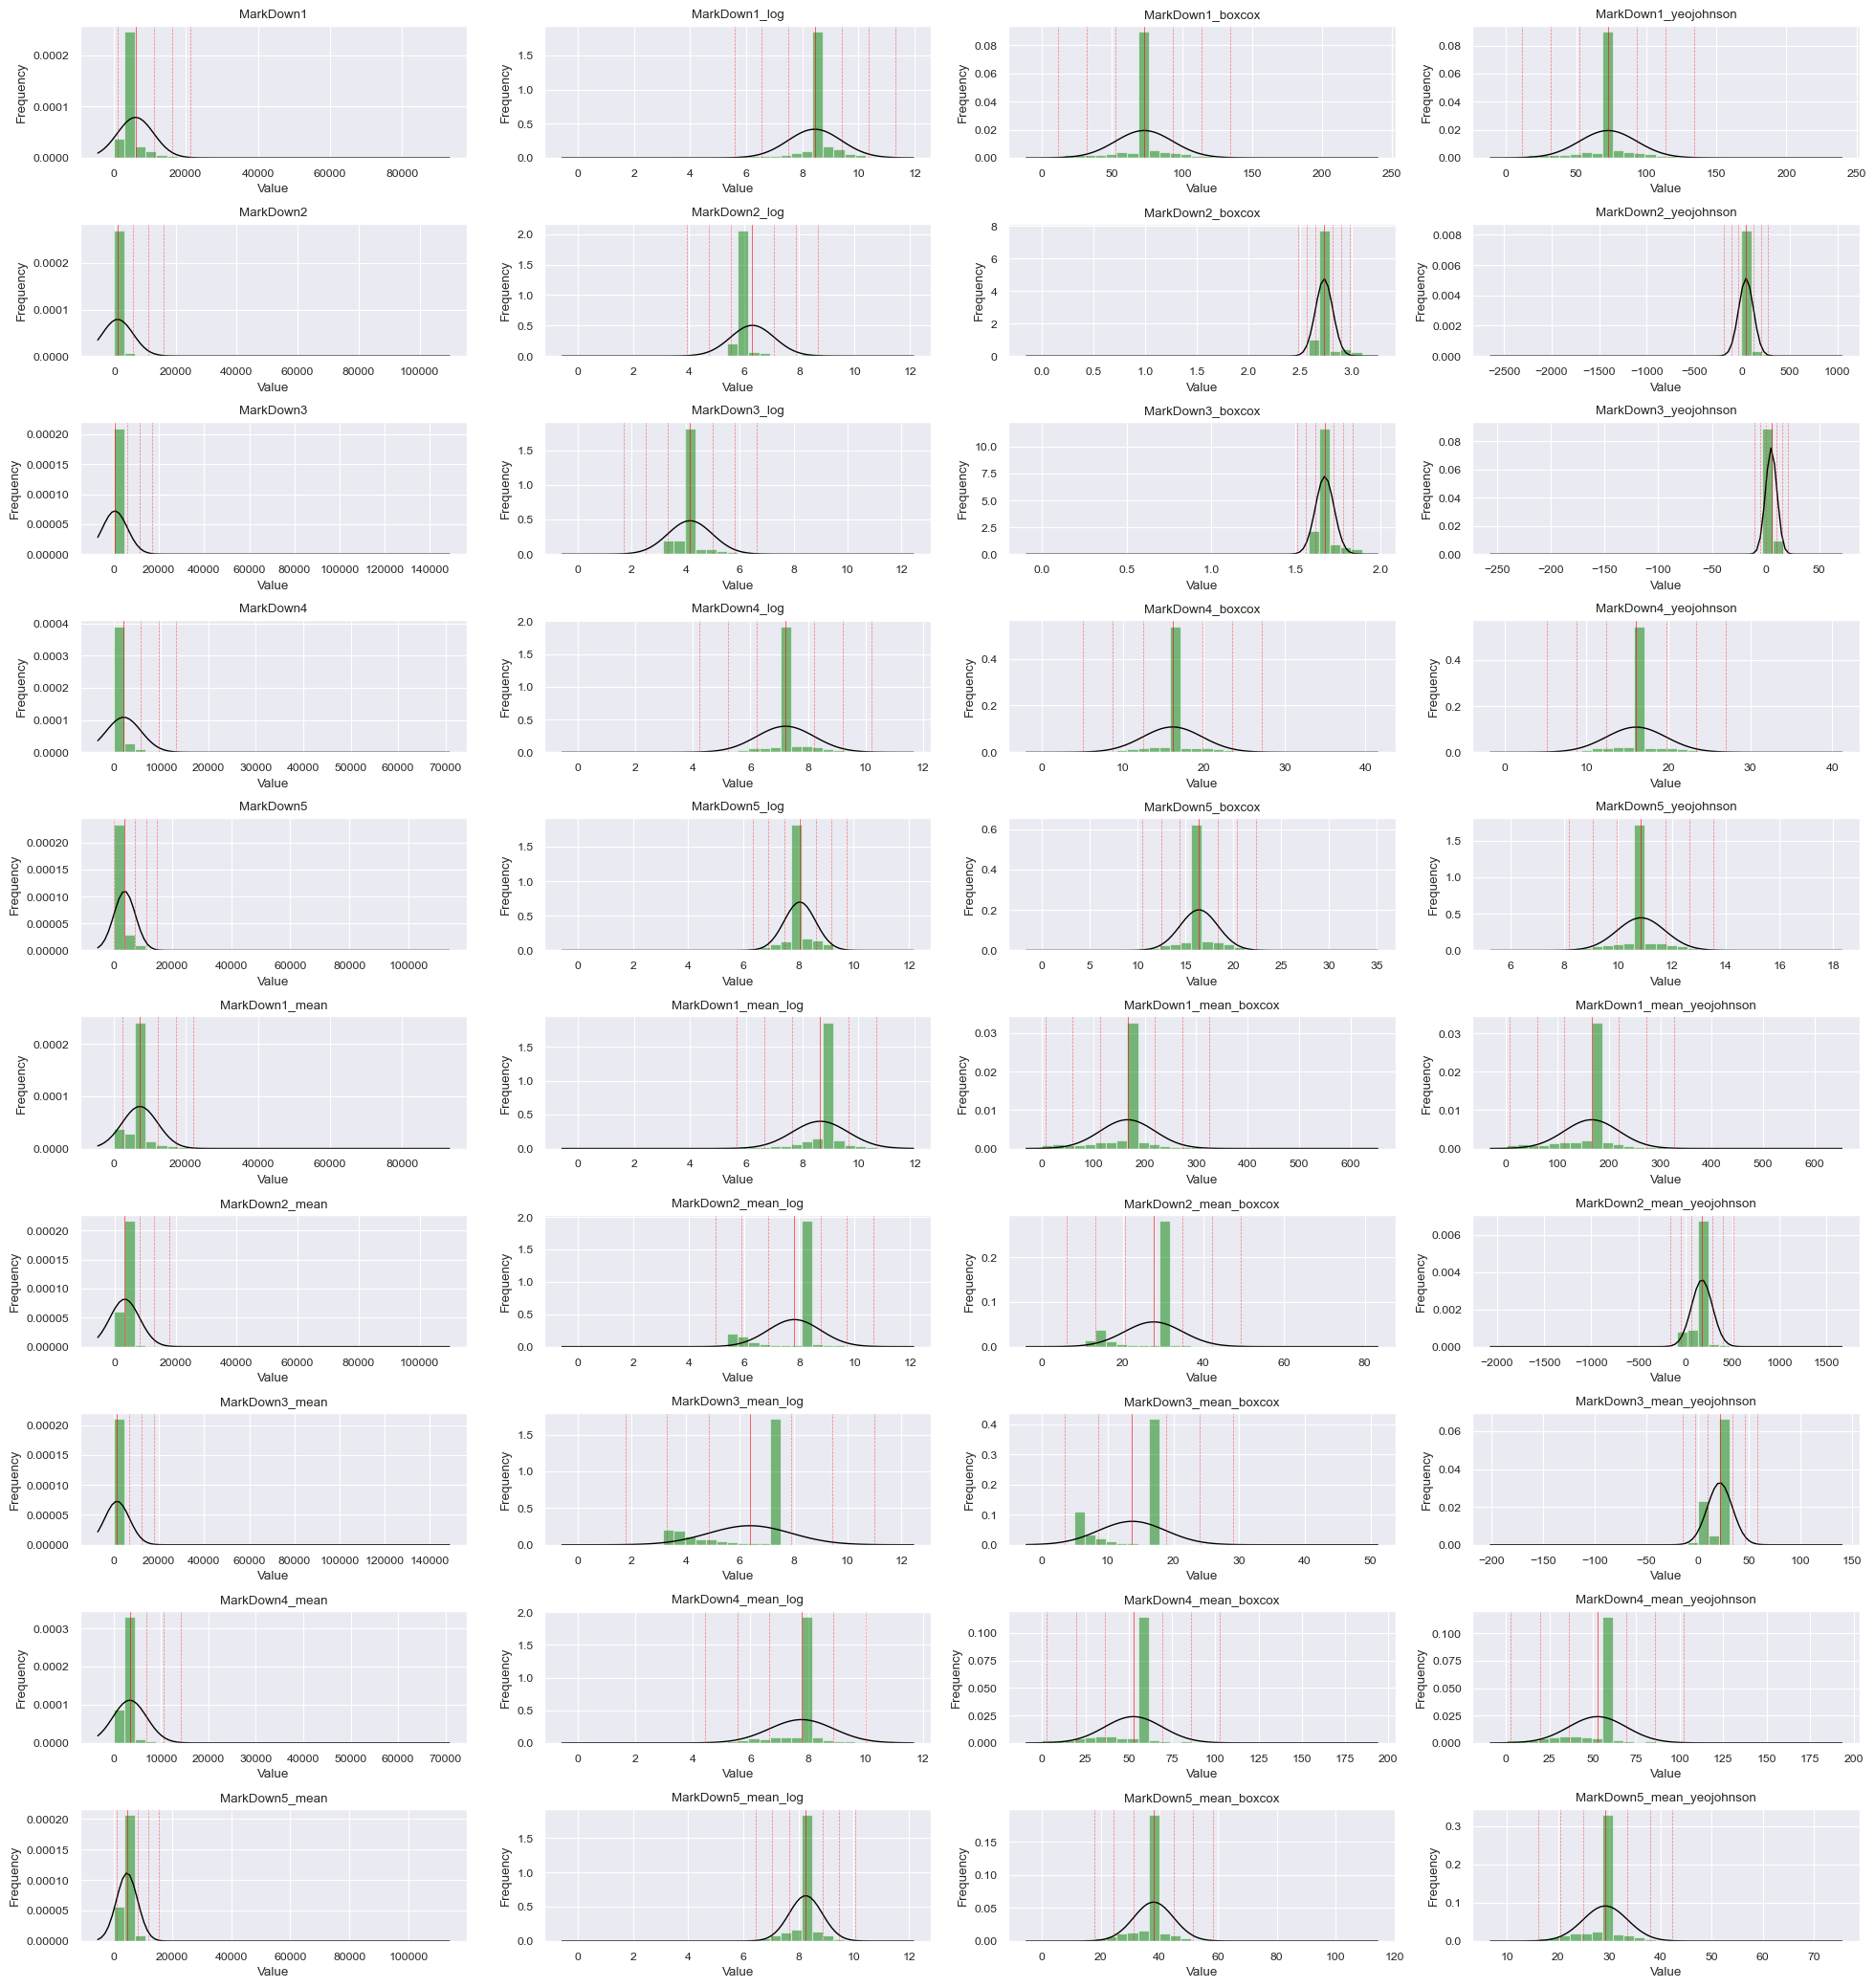

In [40]:
_, axes = plt.subplots(10, 4, figsize=(24,26))
plt.subplots_adjust(hspace=0.5)
for i, row in enumerate(feature_engineering):
    for j, col in enumerate(['', '_log', '_boxcox', '_yeojohnson']):
        ser = df[row+col]
        axes[i,j].hist(ser, bins=30, alpha=0.5, color='g', density=True)

        mean = np.mean(ser)
        std = np.std(ser)
        xmin, xmax = axes[i,j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        axes[i,j].plot(x, p, 'k', linewidth=1)

        for k in range(4):
            linestyle = 'dashed' if k != 0 else 'solid'
            s = mean + k * std
            if s <= ser.max():
                axes[i,j].axvline(s, color='r', linestyle=linestyle, linewidth=0.5, alpha=0.5) # label=f'{i}σ' if i == 1 else ""
            s = mean - k * std
            if s >= ser.min():
                axes[i,j].axvline(s, color='r', linestyle=linestyle, linewidth=0.5, alpha=0.5)

        axes[i,j].set_title(ser.name)
        axes[i,j].set_xlabel('Value')
        axes[i,j].set_ylabel('Frequency')

In [41]:
def drop_high_corr_columns(df, target_col, threshold=0.95):

    features = df.drop(columns=[target_col])
    target = df[target_col]

    # Calculate correlation matrix for features
    corr_matrix = features.corr().abs()

    # Calculate correlation with target
    target_corr = features.corrwith(target).abs()

    # Find pairs of features with high correlation
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find column pairs with correlation > threshold
    high_corr_pairs = [
        (column, row)
        for column in upper_triangle.columns
        for row in upper_triangle.index
        if upper_triangle.loc[row, column] > threshold
    ]

    # Determine which columns to drop
    cols_to_drop = set()

    for col1, col2 in high_corr_pairs:
        # Keep the column with higher correlation to target
        if target_corr[col1] >= target_corr[col2]:
            cols_to_drop.add(col2)
        else:
            cols_to_drop.add(col1)

    # Drop the columns
    df_cleaned = df.drop(columns=list(cols_to_drop))

    print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
    print(f"Remaining features: {len(df_cleaned.columns) - 1}")

    return df_cleaned, cols_to_drop

In [42]:
corr_matrix = df.corr().round(2)
upper_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(bool))
high_corr_matrix = upper_corr[upper_corr > .8].dropna(axis='columns', how='all').dropna(axis='rows', how='all')
high_corr_matrix

,MarkDown4,year,MarkDown1_mean,MarkDown2_mean,MarkDown3_mean,MarkDown4_mean,MarkDown5_mean,MarkDown1_boxcox,MarkDown1_yeojohnson,MarkDown2_boxcox,...,MarkDown2_mean_boxcox,MarkDown2_mean_yeojohnson,MarkDown3_mean_boxcox,MarkDown3_mean_yeojohnson,MarkDown4_mean_log,MarkDown4_mean_boxcox,MarkDown4_mean_yeojohnson,MarkDown5_mean_log,MarkDown5_mean_boxcox,MarkDown5_mean_yeojohnson
Date,NaN,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown1,0.82,NaN,0.98,NaN,NaN,NaN,NaN,0.87,0.87,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown2,NaN,NaN,NaN,0.96,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown3,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown4,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown5,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown1_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown2_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarkDown4_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.81,0.81,NaN,NaN,NaN
MarkDown1_log,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,0.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
corr = {}
for i in [.8,.85,.9,.95,.99]:
    corr[i] = upper_corr[upper_corr > i].count().sum()
corr

{0.8: np.int64(76),
 0.85: np.int64(69),
 0.9: np.int64(45),
 0.95: np.int64(30),
 0.99: np.int64(6)}

In [44]:
df, cols_to_drop = drop_high_corr_columns(df,'Target')

C:\Users\dlela\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dlela\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped 20 columns: {'MarkDown5_mean_yeojohnson', 'MarkDown2_mean_boxcox', 'MarkDown5_log', 'MarkDown4_mean', 'MarkDown3_mean_boxcox', 'MarkDown1_boxcox', 'MarkDown5_mean_boxcox', 'MarkDown4_yeojohnson', 'MarkDown2_mean', 'MarkDown1_mean_log', 'MarkDown5_boxcox', 'MarkDown4_log', 'MarkDown4_mean_yeojohnson', 'MarkDown1_mean_boxcox', 'MarkDown3_mean', 'MarkDown1_mean_yeojohnson', 'MarkDown5_mean', 'MarkDown3_mean_log', 'MarkDown5_mean_log', 'MarkDown1_mean'}
Remaining features: 31


In [45]:
df.to_csv('./data/Clean_training.csv')

In [50]:
# Create or get the experiment
experiment_name = "Data Collection"
mlflow.set_experiment(experiment_name)

# Start MLflow run
with mlflow.start_run(run_name="data_preprocessing_pipeline"):

    # Log basic dataset information
    mlflow.log_param("train_shape", train_df.shape)
    mlflow.log_param("test_shape", test_df.shape)
    mlflow.log_param("stores_shape", stores_df.shape)
    mlflow.log_param("features_shape", features_df.shape)

    # Log merge operations
    mlflow.log_param("merge_operations", "train+stores+features")
    mlflow.log_param("final_shape", df.shape)

    # Log missing value information
    missing_before = train_df.isna().sum().sum()
    missing_cols = fillna
    mlflow.log_param("missing_values_before", missing_before)
    mlflow.log_param("missing_columns", missing_cols)
    mlflow.log_param("imputation_method", "median_and_mean")

    # Log feature engineering transformations
    mlflow.log_param("transformations_applied", ["log", "boxcox", "yeojohnson"])
    mlflow.log_param("transformed_features", feature_engineering)
    mlflow.log_param("total_features_created", len(feature_engineering) * 3)

    # Log correlation removal parameters and results
    mlflow.log_param("correlation_threshold", 0.95)
    mlflow.log_param("target_column", "Target")

    # Log correlation statistics
    for threshold, count in corr.items():
        mlflow.log_metric(f"corr_pairs_above_{threshold}", count)

    # Calculate and log columns dropped
    original_cols = len(df.columns) + len(cols_to_drop)
    mlflow.log_metric("original_column_count", original_cols)
    mlflow.log_metric("dropped_column_count", len(cols_to_drop))
    mlflow.log_metric("final_column_count", len(df.columns))

    # Log data quality metrics
    mlflow.log_metric("missing_values_after", df.isna().sum().sum())
    mlflow.log_metric("duplicate_rows", df.duplicated().sum())

    # Log target variable statistics
    mlflow.log_metric("target_mean", df['Target'].mean())
    mlflow.log_metric("target_std", df['Target'].std())
    mlflow.log_metric("target_min", df['Target'].min())
    mlflow.log_metric("target_max", df['Target'].max())
    mlflow.log_metric("target_median", df['Target'].median())

    # Log feature statistics for important columns
    for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
        if col in df.columns:
            mlflow.log_metric(f"{col}_mean", df[col].mean())
            mlflow.log_metric(f"{col}_std", df[col].std())

    # Create and log correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap='coolwarm', center=0, square=True)
    plt.title('Feature Correlation Matrix After Preprocessing')
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), "correlation_matrix_final.png")
    plt.close()

    # Log distribution plots for transformed features
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, transform in enumerate(['', '_log', '_boxcox', '_yeojohnson']):
        if idx < 4 and f"MarkDown1{transform}" in df.columns:
            df[f"MarkDown1{transform}"].hist(bins=30, ax=axes[idx])
            axes[idx].set_title(f"MarkDown1{transform}")

    plt.tight_layout()
    mlflow.log_figure(fig, "markdown1_transformations.png")
    plt.close()

    # Log data sample
    mlflow.log_text(df.head(10).to_string(), "data_sample.txt")

    # Log data info
    buffer = io.StringIO()
    df.info(buf=buffer)
    mlflow.log_text(buffer.getvalue(), "data_info.txt")

    # Log the list of dropped columns
    if 'cols_to_drop' in locals():
        mlflow.log_text("\n".join(list(cols_to_drop)), "dropped_columns.txt")

    # Save and log the cleaned dataset
    df.to_csv('./data/Clean_training.csv', index=False)
    mlflow.log_artifact('./data/Clean_training.csv')

    # Log tags for organization
    mlflow.set_tag("stage", "data_collection")
    mlflow.set_tag("data_version", "v1.0")
    mlflow.set_tag("preprocessing_complete", True)

    # Log the notebook itself
    mlflow.log_artifact('Data_Collection.ipynb')

    print(f"MLflow Run ID: {mlflow.active_run().info.run_id}")
    print(f"Experiment ID: {mlflow.get_experiment_by_name(experiment_name).experiment_id}")

MLflow Run ID: 03bbaffb9c09450092ee08503528ecc2
Experiment ID: 0
🏃 View run data_preprocessing_pipeline at: https://dagshub.com/qetibakh/Final.mlflow/#/experiments/0/runs/03bbaffb9c09450092ee08503528ecc2
🧪 View experiment at: https://dagshub.com/qetibakh/Final.mlflow/#/experiments/0
